In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class ClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_to_idx = {
            'glioma': 0,
            'meningioma': 1,
            'pituitary': 2,
            'notumor': 3
        }
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir) and class_name in self.class_to_idx:
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# class SegmentationDataset(Dataset):
#     def __init__(self, image_dir, mask_dir, transform=None):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.images = os.listdir(image_dir)

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         img_name = self.images[idx]
#         img_path = os.path.join(self.image_dir, img_name)
#         mask_path = os.path.join(self.mask_dir, img_name)
#         image = Image.open(img_path).convert('RGB')
#         mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale
#         if self.transform:
#             image, mask = self.transform(image, mask)
#         return image, mask

In [4]:
class ResidualInceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualInceptionBlock, self).__init__()
        # Branch 1
        self.branch1 = nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=stride)

        # Branch 2
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=3, stride=1, padding=1)
        )

        # Branch 3
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels // 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels // 4, out_channels // 4, kernel_size=5, stride=1, padding=2)
        )

        # Branch 4 (Pooling)
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=stride, padding=1),
            nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0)
        )

        # Batch Norm and Activation
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Shortcut Connection
        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch_pool(x)
        outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
        outputs = self.bn(outputs)
        residual = self.shortcut(x)
        outputs += residual
        outputs = self.relu(outputs)
        return outputs

def make_layer(block, in_channels, out_channels, num_blocks, stride=1):
    layers = []
    layers.append(block(in_channels, out_channels, stride=stride))
    in_channels = out_channels  # Update in_channels for subsequent blocks
    for _ in range(1, num_blocks):
        layers.append(block(in_channels, out_channels, stride=1))
    return nn.Sequential(*layers)


class DeeperDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(DeeperDetectionModel, self).__init__()
        self.module1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer1 = make_layer(ResidualInceptionBlock, 64, 256, num_blocks=3, stride=1)
        self.layer2 = make_layer(ResidualInceptionBlock, 256, 512, num_blocks=4, stride=2)
        self.layer3 = make_layer(ResidualInceptionBlock, 512, 1024, num_blocks=6, stride=2)
        self.layer4 = make_layer(ResidualInceptionBlock, 1024, 2048, num_blocks=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.module1(x)  # [B, 64, H/4, W/4]
        x = self.layer1(x)   # [B, 256, H/4, W/4]
        x = self.layer2(x)   # [B, 512, H/8, W/8]
        x = self.layer3(x)   # [B, 1024, H/16, W/16]
        x = self.layer4(x)   # [B, 2048, H/32, W/32]
        x = self.avgpool(x)  # [B, 2048, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 2048]
        x = self.fc(x)  # [B, num_classes]
        return x

def create_detection_model(num_classes=2):
    model = DeeperDetectionModel(num_classes=num_classes)
    return model

In [5]:
# class ResidualInceptionBlock_segmentation(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResidualInceptionBlock_segmentation, self).__init__()
#         self.branch1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

#         self.branch2 = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         )

#         self.branch3 = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=5, stride=stride, padding=2)
#         )

#         self.branch_pool = nn.Sequential(
#             nn.MaxPool2d(kernel_size=3, stride=stride, padding=1),
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
#         )

#         self.bn = nn.BatchNorm2d(4 * out_channels)
#         self.relu = nn.ReLU(inplace=True)

#         # Residual connection
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != 4 * out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, 4 * out_channels, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(4 * out_channels)
#             )

#     def forward(self, x):
#         branch1 = self.branch1(x)

#         branch2 = self.branch2(x)

#         branch3 = self.branch3(x)

#         branch4 = self.branch_pool(x)

#         outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
#         outputs = self.bn(outputs)

#         residual = self.shortcut(x)
#         outputs += residual
#         outputs = self.relu(outputs)
#         return outputs

# class UpBlock(nn.Module):
#     def __init__(self, in_channels, skip_channels, out_channels):
#         super(UpBlock, self).__init__()
#         self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
#         self.rib = ResidualInceptionBlock_segmentation(out_channels + skip_channels, out_channels, stride=1)

#     def forward(self, x, skip_connection):
#         x = self.up(x)  # Upsample
#         x = torch.cat([x, skip_connection], dim=1)  # Concatenate with skip connection
#         x = self.rib(x)  # Pass through Residual Inception Block
#         return x

# class SegmentationModel(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super(SegmentationModel, self).__init__()
#         self.enc1 = ResidualInceptionBlock_segmentation(in_channels, 32)  # Output channels: 128
#         self.pool1 = nn.MaxPool2d(2)

#         self.enc2 = ResidualInceptionBlock_segmentation(128, 64)  # Output channels: 256
#         self.pool2 = nn.MaxPool2d(2)

#         self.enc3 = ResidualInceptionBlock_segmentation(256, 128)  # Output channels: 512
#         self.pool3 = nn.MaxPool2d(2)

#         self.enc4 = ResidualInceptionBlock_segmentation(512, 256)  # Output channels: 1024
#         self.pool4 = nn.MaxPool2d(2)

#         self.bottleneck = ResidualInceptionBlock_segmentation(1024, 512)  # Output channels: 2048

#         # Decoder with corrected channel dimensions
#         self.up4 = UpBlock(in_channels=2048, skip_channels=1024, out_channels=256)
#         self.up3 = UpBlock(in_channels=1024, skip_channels=512, out_channels=128)
#         self.up2 = UpBlock(in_channels=512, skip_channels=256, out_channels=64)
#         self.up1 = UpBlock(in_channels=256, skip_channels=128, out_channels=32)

#         self.final_conv = nn.Conv2d(128, out_channels, kernel_size=1)

#     def forward(self, x):
#         # Encoder
#         enc1 = self.enc1(x)  # [B, 128, H, W]
#         enc2 = self.enc2(self.pool1(enc1))  # [B, 256, H/2, W/2]
#         enc3 = self.enc3(self.pool2(enc2))  # [B, 512, H/4, W/4]
#         enc4 = self.enc4(self.pool3(enc3))  # [B, 1024, H/8, W/8]

#         # Bottleneck
#         bottleneck = self.bottleneck(self.pool4(enc4))  # [B, 2048, H/16, W/16]

#         # Decoder
#         dec4 = self.up4(bottleneck, enc4)  # [B, 1024, H/8, W/8]
#         dec3 = self.up3(dec4, enc3)        # [B, 512, H/4, W/4]
#         dec2 = self.up2(dec3, enc2)        # [B, 256, H/2, W/2]
#         dec1 = self.up1(dec2, enc1)        # [B, 128, H, W]

#         out = self.final_conv(dec1)        # [B, out_channels, H, W]
#         return out

# # Instantiate the model
# def create_segmentation_model(in_channels=3, out_channels=1):
#     model = SegmentationModel(in_channels=in_channels, out_channels=out_channels)
#     return model

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [7]:
classification_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# class SegmentationTransform:
#     def __init__(self):
#         self.image_transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406],
#                                  [0.229, 0.224, 0.225])
#         ])

#     def __call__(self, image, mask):
#         image = self.image_transform(image)
#         mask = mask.resize((224, 224), resample=Image.NEAREST)
#         mask = np.array(mask, dtype=np.float32)
#         mask = np.expand_dims(mask, axis=0)  # Add channel dimension
#         mask = torch.from_numpy(mask)
#         mask = mask / 255.0  # Scale mask to [0, 1] range if needed
#         return image, mask

train_dataset = ClassificationDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=classification_transform)
val_dataset = ClassificationDataset(root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=classification_transform)
# test_dataset = ClassificationDataset(root_dir='./Dataset_Arghadip/Test', transform=classification_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# segmentation_image_dir = './Segmentaion_dataset/images'
# segmentation_mask_dir = './Segmentaion_dataset/masks'

# segmentation_transform = SegmentationTransform()
# segmentation_dataset = SegmentationDataset(image_dir=segmentation_image_dir,
#                                            mask_dir=segmentation_mask_dir,
#                                            transform=segmentation_transform)

# segmentation_loader = DataLoader(segmentation_dataset, batch_size=8, shuffle=True)

In [8]:
# classification_model = models.resnet18(pretrained=True)
# num_ftrs = classification_model.fc.in_features
# classification_model.fc = nn.Linear(num_ftrs, 4)  # 4 classes
# classification_model = classification_model.to(device)

In [9]:
# model1 = MICRO_SEM(3)
# model2 = MESO_SEM(3)
# model3 = MACRO_SEM(3)

In [10]:
# from torchinfo import summary
# summary_ = summary(model3, input_size = (32, 3, 224, 224))
# summary_

In [11]:
classification_model = create_detection_model(num_classes = 4)
classification_model = classification_model.to(device)
# segmentation_model = create_segmentation_model(3, 1)
# segmentation_model = segmentation_model.to(device)

In [12]:
# from torchview import draw_graph
# import graphviz as gv
# gv.set_jupyter_format('svg')

# classification_model_graph = draw_graph(classification_model, input_size = (8, 3, 256, 256), graph_name = 'classification_model', expand_nested = True, save_graph = True, directory = "./Architecture")


In [13]:
# segmentation_model_graph = draw_graph(segmentation_model, input_size = (8, 3, 256, 256), graph_name = 'segmentation_model', expand_nested = True, save_graph = True, directory = "./Architecture")

In [14]:
# gv.render(engine = 'dot', format = 'svg', filepath = './Architecture/classification_model.gv')
# gv.render(engine = 'dot', format = 'pdf', filepath = './Architecture/classification_model.gv')

# gv.render(engine = 'dot', format = 'svg', filepath = './Architecture/segmentation_model.gv')
# gv.render(engine = 'dot', format = 'pdf', filepath = './Architecture/segmentation_model.gv')

In [15]:
!pip install torchinfo


In [16]:
from torchinfo import summary
summary_ = summary(classification_model, input_size = (16, 3, 256, 256))
summary_

Layer (type:depth-idx)                   Output Shape              Param #
DeeperDetectionModel                     [16, 4]                   --
├─Sequential: 1-1                        [16, 64, 64, 64]          --
│    └─Conv2d: 2-1                       [16, 64, 128, 128]        9,472
│    └─BatchNorm2d: 2-2                  [16, 64, 128, 128]        128
│    └─ReLU: 2-3                         [16, 64, 128, 128]        --
│    └─MaxPool2d: 2-4                    [16, 64, 64, 64]          --
├─Sequential: 1-2                        [16, 256, 64, 64]         --
│    └─ResidualInceptionBlock: 2-5       [16, 256, 64, 64]         --
│    │    └─Conv2d: 3-1                  [16, 64, 64, 64]          4,160
│    │    └─Sequential: 3-2              [16, 64, 64, 64]          41,216
│    │    └─Sequential: 3-3              [16, 64, 64, 64]          106,752
│    │    └─Sequential: 3-4              [16, 64, 64, 64]          4,160
│    │    └─BatchNorm2d: 3-5             [16, 256, 64, 64]        

In [17]:
criterion_classification = nn.CrossEntropyLoss()
optimizer_classification = optim.Adam(classification_model.parameters(), lr=1e-4)

# criterion_segmentation = nn.BCEWithLogitsLoss()
# optimizer_segmentation = optim.Adam(segmentation_model.parameters(), lr=1e-4)

In [18]:
# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     running_corrects = 0

#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

#     epoch_loss = running_loss / len(train_loader)
#     epoch_acc = running_corrects.double() / len(train_loader)

#     print('Epoch {}/{}: Loss: {:.4f} Acc: {:.4f}'.format(
#         epoch+1, num_epochs, epoch_loss, epoch_acc))


In [19]:
from tqdm.notebook import tqdm

num_epochs = 30
total_len = len(train_loader) + len(val_loader)

train_losses = np.zeros(num_epochs)
test_losses = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_acc = np.zeros(num_epochs)

best_test_acc = 0

for epoch in range(num_epochs):
    epoch_str = str(epoch + 1).rjust(len(str(num_epochs)), " ")
    with tqdm(total = total_len, desc = f"Epoch [ {epoch_str}/{num_epochs} ] : ") as pbar:

        classification_model.train()
        n_correct = 0
        n_total = 0
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer_classification.zero_grad()

            outputs = classification_model(inputs)
            loss = criterion_classification(outputs, targets)
            train_loss.append(loss.item())

            loss.backward()
            optimizer_classification.step()

            _, prediction = torch.max(outputs, 1)

            n_correct += (prediction == targets).sum().item()
            n_total += targets.shape[0]

            pbar.update(1)

        # before_lr = optimizer.param_groups[0]["lr"]
        # scheduler.step()
        # after_lr = optimizer.param_groups[0]["lr"]

        train_loss = np.mean(train_loss)
        train_acc_real = n_correct/n_total
        train_losses[epoch] = train_loss
        train_acc[epoch] = train_acc_real

        classification_model.eval()
        n_correct = 0
        n_total = 0
        test_loss = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = classification_model(inputs)

                loss = criterion_classification(outputs, targets)
                test_loss.append(loss.item())

                _, prediction = torch.max(outputs, 1)

                n_correct += (prediction == targets).sum().item()
                n_total += targets.shape[0]

                pbar.update(1)

        test_loss = np.mean(test_loss)
        test_acc_real = n_correct/n_total
        test_losses[epoch] = test_loss
        test_acc[epoch] = test_acc_real

        pbar.set_description(f"Epoch [ {epoch_str}/{num_epochs} ] ")
        pbar.set_postfix({'Train acc' : f'{train_acc_real:.3f}',
                          'Train loss' : f'{train_loss:.3f}',
                          'Test acc' : f'{test_acc_real:.3f}',
                          'Test loss': f'{test_loss:.3f}'
                        #   'lr_before' : f'{before_lr}',
                        #   'lr_after' : f'{after_lr}'+
                         })

Epoch [  1/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  2/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  3/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  4/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  5/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  6/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  7/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  8/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [  9/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 10/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 11/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 12/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 13/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 14/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 15/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 16/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 17/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 18/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 19/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 20/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 21/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 22/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 23/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 24/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 25/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 26/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 27/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 28/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 29/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

Epoch [ 30/30 ] :   0%|          | 0/439 [00:00<?, ?it/s]

In [26]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [20]:
classification_model.eval()
val_running_corrects = 0

n_correct = 0
n_total = 0

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = classification_model(inputs)

        _, prediction = torch.max(outputs, 1)

        n_correct += (prediction == targets).sum().item()
        n_total += targets.shape[0]

test_acc_real = n_correct/n_total
print('Validation Accuracy: {:.4f}'.format(test_acc_real))

Validation Accuracy: 0.9779


In [21]:
# # import tqdm as tqdm_sim

# for epoch in range(num_epochs):
#     epoch_str = str(epoch + 1).rjust(len(str(num_epochs)), " ")
#     with tqdm(total = len(segmentation_loader), desc = f"Epoch [ {epoch_str}/{num_epochs} ] : ") as pbar:
#         segmentation_model.train()
#         running_loss = 0.0
#         for inputs, masks in segmentation_loader:
#             inputs = inputs.to(device)
#             masks = masks.to(device)
#             optimizer_segmentation.zero_grad()
#             outputs = segmentation_model(inputs)
#             loss = criterion_segmentation(outputs, masks.float())
#             loss.backward()
#             optimizer_segmentation.step()
#             running_loss += loss.item() * inputs.size(0)
#             pbar.update(1)

#         epoch_loss = running_loss / len(segmentation_dataset)
#         pbar.set_description(f"Epoch [ {epoch_str}/{num_epochs} ] ")
#         pbar.set_postfix({'Train loss' : f'{epoch_loss:.3f}'})

In [22]:
# import torch
# from torchvision import transforms
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# classification_model.eval()
# # segmentation_model.eval()

# torch.set_grad_enabled(False)

# classification_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# # segmentation_transform = transforms.Compose([
# #     transforms.Resize((224, 224)),
# #     transforms.ToTensor(),
# #     transforms.Normalize([0.485, 0.456, 0.406],
# #                          [0.229, 0.224, 0.225])
# # ])

# test_image_path = './kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0000.jpg'
# original_image = Image.open(test_image_path).convert('RGB')

# input_image_classification = classification_transform(original_image)
# input_image_classification = input_image_classification.unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]

# # input_image_segmentation = segmentation_transform(original_image)
# # input_image_segmentation = input_image_segmentation.unsqueeze(0).to(device)  # Shape: [1, 3, 224, 224]

# classification_output = classification_model(input_image_classification)
# _, predicted_class_idx = torch.max(classification_output, 1)
# predicted_class_idx = predicted_class_idx.item()

# idx_to_class = {0: 'glioma', 1: 'meningioma', 2: 'pituitary', 3: 'notumor'}
# predicted_class_name = idx_to_class[predicted_class_idx]

# # segmentation_output = segmentation_model(input_image_segmentation)['out']  # Output shape: [1, 1, 224, 224]

# # segmentation_output = segmentation_output.squeeze(0).cpu()  # Shape: [1, 224, 224]
# # segmentation_output = torch.sigmoid(segmentation_output)  # Values between 0 and 1
# # threshold = 0.5
# # mask = (segmentation_output > threshold).float()
# # mask = mask.squeeze().numpy()  # Shape: [224, 224]

# # mask = Image.fromarray((mask * 255).astype(np.uint8))
# # mask = mask.resize(original_image.size, resample=Image.NEAREST)

# # overlay = original_image.copy()
# # overlay.putalpha(mask)

# fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# axs[0].imshow(original_image)
# axs[0].set_title('Original Image')
# axs[0].axis('off')

# # axs[1].imshow(mask, cmap='gray')
# # axs[1].set_title('Segmentation Mask')
# # axs[1].axis('off')

# # axs[2].imshow(overlay)
# # axs[2].set_title('Overlay')
# # axs[2].axis('off')

# axs[3].text(0.5, 0.5, f'Predicted Class:\n{predicted_class_name}', fontsize=18, ha='center')
# axs[3].set_axis_off()

# plt.show()

In [23]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, r2_score
import numpy as np

# Assuming you have your model, data loaders, and device set up
classification_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classification_model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate metrics
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
auc = roc_auc_score(all_labels, all_probs, average='weighted', multi_class='ovr')
r2 = r2_score(all_labels, all_preds)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')
print(f'R2 Score: {r2}')

Precision: 0.9781851225771756
Recall: 0.9778794813119756
F1 Score: 0.9776634373410089
AUC: 0.9993529332786371
R2 Score: 0.9761564462897903


In [27]:
# Save the model
torch.save(classification_model.state_dict(), '/content/model_Full.pth')


# # Later, to load the model, you would use:
# classification_model.load_state_dict(torch.load('/kaggle/working/model.pth'))
# classification_model.eval()  # Make sure to call eval mode when evaluating

In [28]:
from google.colab import files
files.download('/content/model_Full.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/tmp/ipython-input-895635046.py:112: RuntimeWarning: invalid value encountered in cast
  heatmap_colormap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)


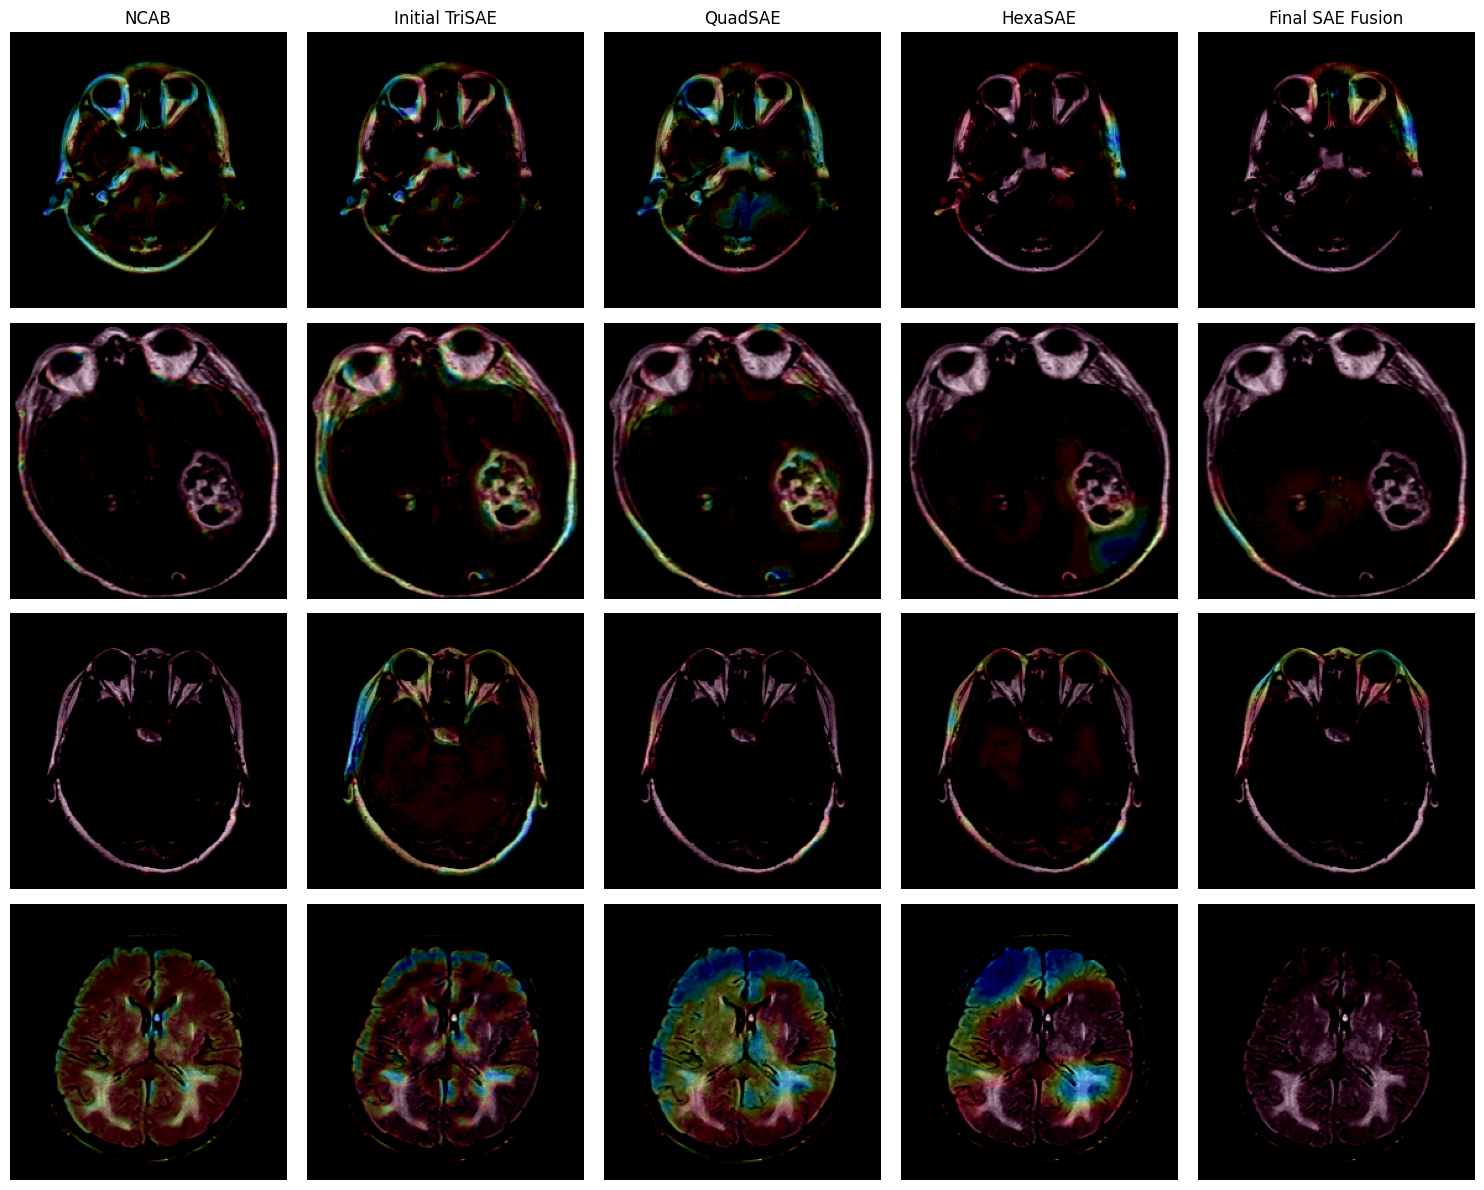

In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_image, target_class):
        self.model.eval()
        output = self.model(input_image)
        self.model.zero_grad()
        class_loss = F.cross_entropy(output, target_class)
        class_loss.backward()
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.detach().cpu().numpy()

def show_cam_on_image(img, mask, title):
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    plt.imshow(cam)
    plt.axis('off')
    plt.title(title)

def load_model(model_path):
    model = create_detection_model(num_classes=4)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model = model.to(device)
    model.eval()
    return model

# Hyperparameters
model_path = '/content/model_Full.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
classification_model = load_model(model_path)

# Image paths
image_paths = {
    'glioma': '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0003.jpg',
    'meningioma': '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0001.jpg',
    'pituitary': '/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-piTr_0000.jpg',
    'no_tumor': '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg'
}

# Preprocess images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

input_images = {k: preprocess(Image.open(v).convert('RGB')).unsqueeze(0) for k, v in image_paths.items()}
target_classes = {
    'glioma': torch.tensor([0]).to(device),
    'meningioma': torch.tensor([1]).to(device),
    'pituitary': torch.tensor([2]).to(device),
    'no_tumor': torch.tensor([3]).to(device)
}

# Specify target layers for Grad-CAM
target_layers = [
    classification_model.module1[3],    # MaxPool in module1
    classification_model.layer1[-1].bn, # BatchNorm in the last block of layer1
    classification_model.layer2[-1].bn, # BatchNorm in the last block of layer2
    classification_model.layer3[-1].bn, # BatchNorm in the last block of layer3
    classification_model.layer4[-1].bn  # BatchNorm in the last block of layer4
]

# Module names
module_names = ['NCAB', 'Initial TriSAE', 'QuadSAE', 'HexaSAE', 'Final SAE Fusion']
# Tumor types
tumor_types = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# Generate and display Grad-CAM heatmaps
fig, axes = plt.subplots(len(tumor_types), len(module_names), figsize=(15, 12))

for row, image_type in enumerate(tumor_types):
    input_image = input_images[image_type].to(device)
    target_class = target_classes[image_type]
    input_image_np = input_image.cpu().numpy().squeeze().transpose(1, 2, 0)

    for col, target_layer in enumerate(target_layers):
        grad_cam = GradCAM(model=classification_model, target_layer=target_layer)
        heatmap = grad_cam.generate(input_image, target_class)
        mask = cv2.resize(heatmap, (input_image_np.shape[1], input_image_np.shape[0]))
        heatmap_colormap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        cam = np.float32(heatmap_colormap) / 255 + np.float32(input_image_np)
        cam = cam / np.max(cam)

        axes[row, col].imshow(cam)
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(module_names[col], fontsize=12)
    axes[row, 0].set_ylabel(image_type, fontsize=12)

plt.tight_layout()
plt.show()